<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

import tensorflow.keras as keras
print("Keras:{}".format(keras.__version__))

import os
import sys
print('Python interpreter and version:',sys.version)

NumPy:1.14.1
Pandas:0.23.4
TensorFlow:1.10.0
Keras:2.1.6-tf
Python interpreter and version: 3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]


In [2]:
dsroot = os.path.join(os.path.expanduser('~'),'datasets','kaggle-retailrocket')
os.listdir(dsroot)

['item_properties_part2.csv',
 'category_tree.csv',
 'events.csv',
 'item_properties_part1.csv',
 'ecommerce-dataset.zip']

In [49]:
events = pd.read_csv(os.path.join(dsroot,'events.csv'))
print('Event data\n',events.head())

Event data
        timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN


In [39]:
print('Unique counts:',events.nunique())

Unique counts: timestamp        2750455
visitorid        1407580
event                  3
itemid            235061
transactionid      17672
dtype: int64


In [40]:
print('Kind of events:',events.event.unique())

Kind of events: ['view' 'addtocart' 'transaction']


In [50]:
events.event.replace(to_replace=dict(view=1, 
                                     addtocart=2, 
                                     transaction=3), 
                     inplace=True)
events.drop(['transactionid'],axis=1,inplace=True)
#events = events.sample(frac=1).reset_index(drop=True)
events = events.reindex(np.random.permutation(events.index))
events=events[0:100000]

In [51]:

split_1 = int(0.8 * len(events))
split_2 = int(0.9 * len(events))
train = events[:split_1]
valid = events[split_1:split_2]
test = events[split_2:]
print(train.head())
print(valid.head())
print(test.head())

             timestamp  visitorid  event  itemid
182248   1433890629202      69463      1  410583
1964011  1432768233733     547852      1  186702
1351571  1442010683576     509828      1  102229
2357731  1436935579507    1155559      1  107488
1646786  1431471598261     244723      1   26991
             timestamp  visitorid  event  itemid
1033643  1440443265089     830465      1  122941
2539686  1437698224970    1401351      1  231292
2156627  1436221585754     323785      1  172148
1429594  1442337153323     719099      1  215363
1299301  1441765675058    1407019      1  383828
             timestamp  visitorid  event  itemid
1772955  1432009715283    1051469      1  339763
1491331  1430761896866     899757      1    9978
2699432  1438184306316    1150086      1  400077
1732765  1431814050668    1399029      1  164941
879607   1439710441391    1383393      1  261515


In [52]:
n_visitors = events.visitorid.nunique()
n_items = events.itemid.nunique()
n_latent_factors = 5

In [53]:
from tensorflow.keras.layers import Input, Embedding, Flatten
item_input = Input(shape=[1],name='Items')
item_embed = Embedding(n_items + 1,
                           n_latent_factors, 
                           name='ItemsEmbedding')(item_input)
item_vec = Flatten(name='ItemsFlatten')(item_embed)

visitor_input = keras.layers.Input(shape=[1],name='Visitors')
visitor_embed = Embedding(n_visitors + 1, 
                              n_latent_factors,
                              name='VisitorsEmbedding')(visitor_input)
visitor_vec = Flatten(name='VisitorsFlatten')(visitor_embed)

dot_prod = keras.layers.dot([item_vec, visitor_vec],axes=[1,1],
                             name='DotProduct') 
model = keras.Model([item_input, visitor_input], dot_prod)
model.compile('adam', 'mse')

In [54]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Items (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Visitors (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
ItemsEmbedding (Embedding)      (None, 1, 5)         250440      Items[0][0]                      
__________________________________________________________________________________________________
VisitorsEmbedding (Embedding)   (None, 1, 5)         437595      Visitors[0][0]                   
__________________________________________________________________________________________________
ItemsFlatt

In [55]:
keras.utils.plot_model(model, 
                       to_file='model.png', 
                       show_shapes=True, 
                       show_layer_names=True)
from IPython import display
display.display(display.Image('model.png'))

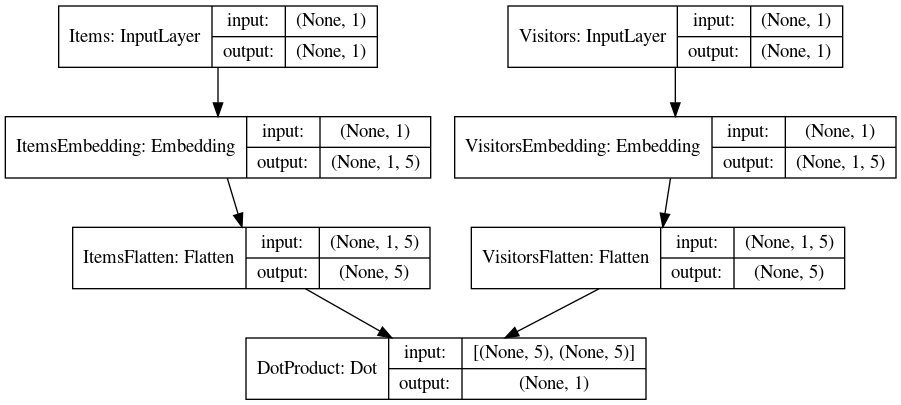

In [57]:
model.fit([train.visitorid, train.itemid], train.event, epochs=100)

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
80000/80000 [==============================] - 5s 59us/step - loss: 1.1357
Epoch 2/100
80000/80000 [==============================] - 5s 62us/step - loss: 1.1351
Epoch 3/100
80000/80000 [==============================] - 6s 69us/step - loss: 1.1345
Epoch 4/100
80000/80000 [==============================] - 5s 62us/step - loss: 1.1342
Epoch 5/100
80000/80000 [==============================] - 5s 57us/step - loss: 1.1339
Epoch 6/100
80000/80000 [==============================] - 4s 56us/step - loss: 1.1338
Epoch 7/100
80000/80000 [==============================] - 4s 56us/step - loss: 1.1337
Epoch 8/100
80000/80000 [==============================] - 4s 55us/step - loss: 1.1336
Epoch 9/100
80000/80000 [==============================] - 4s 55us/step - loss: 1.1336
Epoch 10/100
80000/80000 [==============================] - 4s 55us/step - loss: 1.1336
Epoch 11/100
80000/80000 [==============================] - 4s 56us/step - loss: 1.1336
Epoch 12/100
80000/80000 [===============

80000/80000 [==============================] - 5s 58us/step - loss: 1.1336
Epoch 95/100
80000/80000 [==============================] - 5s 60us/step - loss: 1.1336
Epoch 96/100
80000/80000 [==============================] - 5s 64us/step - loss: 1.1336
Epoch 97/100
80000/80000 [==============================] - 5s 60us/step - loss: 1.1336
Epoch 98/100
80000/80000 [==============================] - 4s 56us/step - loss: 1.1336
Epoch 99/100
80000/80000 [==============================] - 5s 58us/step - loss: 1.1336
Epoch 100/100
80000/80000 [==============================] - 5s 58us/step - loss: 1.1336


In [72]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense

n_lf_visitor = 5
n_lf_item = 5

item_input = Input(shape=[1],name='Items')
item_embed = Embedding(n_items + 1,
                           n_lf_visitor, 
                           name='ItemsEmbedding')(item_input)
item_vec = Flatten(name='ItemsFlatten')(item_embed)

visitor_input = Input(shape=[1],name='Visitors')
visitor_embed = Embedding(n_visitors + 1, 
                              n_lf_item,
                              name='VisitorsEmbedding')(visitor_input)
visitor_vec = Flatten(name='VisitorsFlatten')(visitor_embed)

concat = keras.layers.concatenate([item_vec, visitor_vec], name='Concat')
fc_1 = Dense(80,name='FC-1')(concat)
fc_2 = Dense(40,name='FC-2')(fc_1)
fc_3 = Dense(20,name='FC-3', activation='relu')(fc_2)

output = Dense(1, activation='relu',name='Output')(fc_3)

adam = keras.optimizers.Adam(lr=0.005)
model = keras.Model([item_input, visitor_input], output)
model.compile(optimizer=adam,loss= 'mae')

In [73]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Items (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Visitors (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
ItemsEmbedding (Embedding)      (None, 1, 5)         250440      Items[0][0]                      
__________________________________________________________________________________________________
VisitorsEmbedding (Embedding)   (None, 1, 5)         437595      Visitors[0][0]                   
__________________________________________________________________________________________________
ItemsFlatt

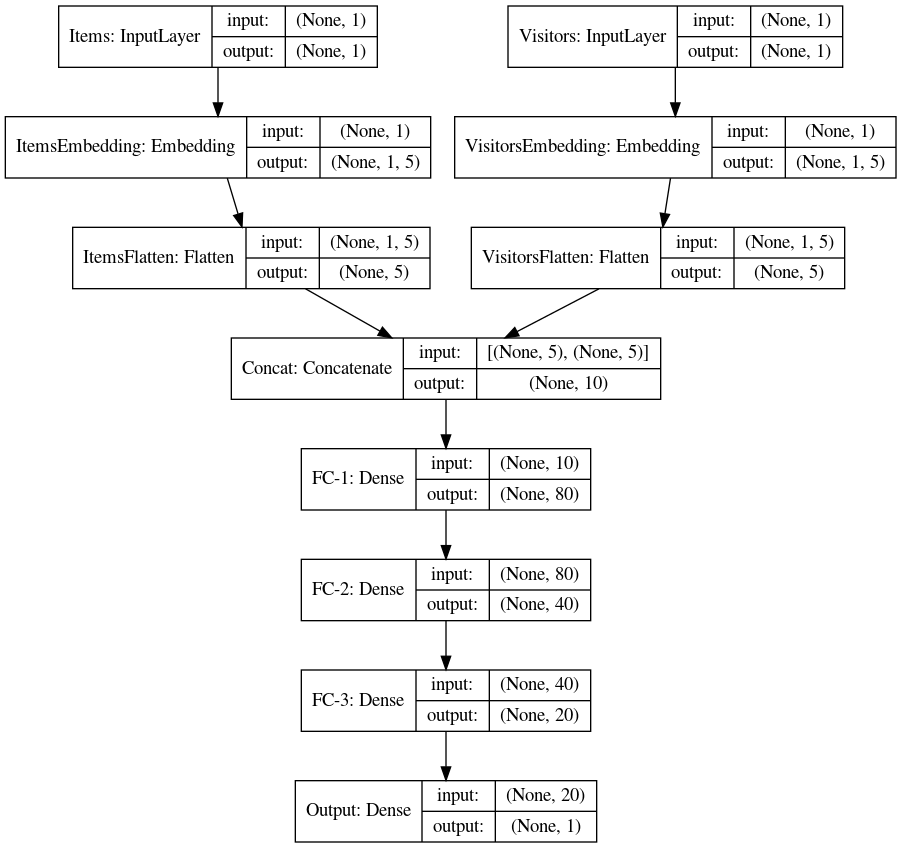

In [74]:
keras.utils.plot_model(model, 
                       to_file='model.png', 
                       show_shapes=True, 
                       show_layer_names=True)
from IPython import display
display.display(display.Image('model.png'))

In [75]:
model.fit([train.visitorid, train.itemid], train.event, epochs=50)

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
80000/80000 [==============================] - 8s 105us/step - loss: 0.0571
Epoch 2/50
80000/80000 [==============================] - 8s 103us/step - loss: 0.0465
Epoch 3/50
80000/80000 [==============================] - 8s 102us/step - loss: 0.0459
Epoch 4/50
80000/80000 [==============================] - 8s 103us/step - loss: 0.0449
Epoch 5/50
80000/80000 [==============================] - 8s 105us/step - loss: 0.0442
Epoch 6/50
80000/80000 [==============================] - 8s 105us/step - loss: 0.0439
Epoch 7/50
80000/80000 [==============================] - 8s 106us/step - loss: 0.0446
Epoch 8/50
80000/80000 [==============================] - 8s 104us/step - loss: 0.0436
Epoch 9/50
80000/80000 [==============================] - 8s 100us/step - loss: 0.0436
Epoch 10/50
80000/80000 [==============================] - 8s 95us/step - loss: 0.0435
Epoch 11/50
80000/80000 [==============================] - 8s 100us/step - loss: 0.0434
Epoch 12/50
80000/80000 [=================

In [76]:
score = model.evaluate([test.visitorid, test.itemid], test.event)

10000/10000 [==============================] - 0s 29us/step


In [77]:
print(score)

0.036945688772201536
